# You are what you eat - Relating Demographic Data to Food Consumption Habits

In [1]:
#%matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # needed for heatmap
from os.path import join
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
plt.rcParams['figure.figsize'] = [7, 5]

In [2]:
# define paths for data
FOLDER_PATH = 'data'
PURCHASES_PATH = 'area_level_purchases'
OSWARD_GROCERY = 'year_osward_grocery.csv'
WARD_ATLAS = 'ward-atlas-data.csv'

ward_data_path = join(FOLDER_PATH, PURCHASES_PATH, OSWARD_GROCERY)
atlas_data_path = join(FOLDER_PATH, WARD_ATLAS)

# load the data sets
df_ward = pd.read_csv(ward_data_path, sep=',', index_col=0)
df_atlas = pd.read_csv(atlas_data_path, sep=',', encoding='iso-8859-1')

The `df_atlas` data set looks very messy. Row 0 contains info about the data. For every ward and demographic marker yearly (from 2001 to 2006) values exist in columns. According to the [source](https://data.london.gov.uk/dataset/ward-profiles-and-atlas) this data set was collected in September 2015 with the most up-to-date information available. Thus, for many markers, the last available information dates to 2015 or even earlier (e.g. 2013). Our first step is to clean the data set from outdated columns and only keep the most up-to-date demographic markers.

As indicated by the title, we are interested in demographic markers which help classifying different classes of people. These are for example gender, religion, ethnicity, wealth, age. Thus, in the following, we drop columns which we deem not helpful in classifying people into groups. We acknowledge that this process can be rather biased, however, as the data set has 946 columns, we see the need to reduce the data set's complexity.

In [3]:
def drop_redundant_data(df_atlas):
    # clean age (columns after 2013 are projections, therefore keep 2013 columns)
    cond = df_atlas.columns.str.startswith('Population and Age') & ~df_atlas.columns.str.contains('2013')
    df_atlas = df_atlas.loc[:, ~cond]
    # drop absolute population values
    df_atlas = df_atlas.drop(['Population and Age; Population Estimates and Projections; 2013',
                   'Population and Age; Aged 0-15; 2013',
                   'Population and Age; Aged 16-64; 2013',
                   'Population and Age; Aged 65+; 2013',
                   'Population and Age; All ages; 2013',
                   'Population and Age; Mean age; 2013',
                   'Population and Age; Median age; 2013'], axis=1)
    # delete population density
    cond = df_atlas.columns.str.startswith('Area and Density')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete the 18 ethnic groups for now, as they add complexity
    cond = df_atlas.columns.str.startswith('Diversity; Ethnic Group 18 groups')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household language (of no interest) 
    cond = df_atlas.columns.str.startswith('Diversity; Household Language - 2011 Census')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household composition data
    cond = df_atlas.columns.str.startswith('Household composition')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household repossesion
    cond = df_atlas.columns.str.startswith('Home repossessions')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated birth and death markers
    cond = df_atlas.columns.str.startswith('Births and deaths')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated life expectancy
    cond = df_atlas.columns.str.startswith('Life Expectancy')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated housing markers
    cond = df_atlas.columns.str.startswith('Housing type and Tenure')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('House Prices')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete tax related data (not of interest)
    cond = df_atlas.columns.str.startswith('Dwellings and Council tax')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete dwelling data which is not of interest
    cond = df_atlas.columns.str.startswith('Property Type') | df_atlas.columns.str.startswith('Size of dwellings') | df_atlas.columns.str.startswith('Property build period')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated income data
    cond = df_atlas.columns.str.startswith('Household Income') & ~df_atlas.columns.str.contains('2012/13')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated employment data
    cond = df_atlas.columns.str.startswith('Employment')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete benefits claimants and jobseekers allowance
    cond = df_atlas.columns.str.startswith('Benefits claimants') | df_atlas.columns.str.startswith('Jobseekers Allowance')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete out of work families
    cond = df_atlas.columns.str.startswith('Out-of-Work Families')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated poverty
    cond = df_atlas.columns.str.startswith('Children in Poverty')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated "intelligence" scores
    cond = df_atlas.columns.str.startswith('GCSE')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('A-Level Point Scores')
    df_atlas = df_atlas.loc[:, ~cond]
    # pupil abscence not if interest
    cond = df_atlas.columns.str.startswith('Pupil Absence')
    df_atlas = df_atlas.loc[:, ~cond]
    # individual crimes not of interest, only crime rate
    cond = df_atlas.columns.str.startswith('Crime') # & ~df_atlas.columns.str.contains('Total crime rate; 2014/15')
    df_atlas = df_atlas.loc[:, ~cond]
    # further columns not of interest
    cond = df_atlas.columns.str.startswith('Fires') | df_atlas.columns.str.startswith('Ambulance') \
    | df_atlas.columns.str.startswith('Binge Drinking') | df_atlas.columns.str.startswith('Road Casualties') \
    | df_atlas.columns.str.startswith('Air Emissions') | df_atlas.columns.str.startswith('Land Use') \
    | df_atlas.columns.str.startswith('Access to green space and nature') | df_atlas.columns.str.startswith('Public Transport Accessibility')\
    | df_atlas.columns.str.startswith('Car access') | df_atlas.columns.str.startswith('Travel to work by bicycle') \
    | df_atlas.columns.str.startswith('Workplace employment') | df_atlas.columns.str.startswith('Nat Insurance No. registrations') \
    | df_atlas.columns.str.startswith('Election turnout')
    df_atlas = df_atlas.loc[:, ~cond]
    # obesity already available in cleaned format
    cond = df_atlas.columns.str.startswith('Childhood Obesity Prevalence')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete old indices of deprivation
    cond = df_atlas.columns.str.startswith('Indices of Deprivation') & ~df_atlas.columns.str.contains('2010')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('Indices of Deprivation') & ~df_atlas.columns.str.endswith('Average Score; 2010')
    df_atlas = df_atlas.loc[:, ~cond]
    
    df_atlas.drop('Unnamed: 0', axis=1, inplace=True)
    df_atlas.drop(df_atlas.index[-3:], inplace=True)
    df_atlas.drop(df_atlas.index[0], inplace=True)
    return df_atlas

df_atlas = drop_redundant_data(df_atlas)

In [4]:
# The first 4 columns seem to have a wrong name
df_atlas.rename(columns={'Unnamed: 1': 'New Code', 'Unnamed: 2': 'Borough', 
                         'Unnamed: 3': 'Names'}, inplace=True)

# very long column names, rename columns to more concise names
import re
rename_map = {name: re.sub('.*; ', '', name) for name in df_atlas.columns.values}
# after inspection 'Household Income; Median Modelled Household income (£); 2012/13',
# 'Household Income; Mean Modelled Household income (£); 2012/13',
# 'Happiness and Well-being; Subjective well-being average score, 2011/12 and 2012/13; ',
# and 'Indices of Deprivation; Average Score; 2010' have been replaced too much, manually add those column names
rename_map['Household Income; Median Modelled Household income (£); 2012/13'] = 'Household Income Mean'
rename_map['Household Income; Mean Modelled Household income (£); 2012/13'] = 'Household Income Median'
rename_map['Happiness and Well-being; Subjective well-being average score, 2011/12 and 2012/13; '] = 'Well-Being'
rename_map['Indices of Deprivation; Average Score; 2010'] = 'IOD AVG'
df_atlas.rename(columns=rename_map, inplace=True)
                         
df_atlas.rename(columns={'% No qualifications': 'No qualifications', 
                         '% Highest level of qualification: Level 1 qualifications': 'Level 1 qualifications', 
                         '% Highest level of qualification: Level 2 qualifications': 'Level 2 qualifications', 
                         '% Highest level of qualification: Apprenticeship': 'Apprenticeship qualifications', 
                         '% Highest level of qualification: Level 3 qualifications': 'Level 3 qualifications', 
                         '% Highest level of qualification: Level 4 qualifications and above': 'Level >=4 qualifications',
                         '% Highest level of qualification: Other qualifications': 'Other qualifications', 
                         '% People with Bad or Very Bad Health': 'Bad Health',
                         '% People whose Day-to-day activities are limited a lot': 'Limited activities'},
                inplace=True)

In [5]:
# to numeric conversion
df_atlas.loc[:, 'Aged 0-15':] = df_atlas.loc[:, 'Aged 0-15':].apply(pd.to_numeric, errors='coerce')

In [6]:
age_cols = ['Aged 0-15', 'Aged 16-64', 'Aged 65+'] #sum to 1
ethnicities_cols = ['White', 'Mixed', 'Asian or Asian British', 'Black or Black British', 'Other'] #sum to 1
religion_cols = ['Christian', 'Buddhist', 'Hindu', 'Jewish', 'Muslim', 'Sikh',
       'No religion', 'Other religions', 'Religion not stated'] # sum to 1
born_cols = ['Born in UK', 'Not Born in UK'] # sum to 1
wealth_cols = ['Household Income Median', 'IOD AVG'] #'Well-Being'
qualilication_cols = ['No qualifications', 'Level 1 qualifications', 'Level 2 qualifications',
       'Apprenticeship qualifications', 'Level 3 qualifications',
       'Level >=4 qualifications', 'Other qualifications'] # sum to 1 
disability_cols = ['Bad Health', 'Limited activities']
all_features = age_cols + ethnicities_cols + religion_cols + born_cols + wealth_cols + qualilication_cols + disability_cols

normalizing data

In [7]:
def normalize(df, cols):
    total = df[cols].sum(axis=1)
    df[cols] = df[cols].div(total, axis=0)
    return df

def standartize(df, cols):
    means = df[cols].mean()
    stds = df[cols].std()
    df[cols] = (df[cols] - means) / stds
    return df

def min_max_scaling(df, cols):
    mins = df[cols].min()
    maxs = df[cols].max()
    df[cols] = (df[cols] - mins) / (maxs - mins)
    return df

In [8]:
#normalize
df_atlas[age_cols] /= 100
df_atlas = normalize(df_atlas, ethnicities_cols)
df_atlas = normalize(df_atlas, religion_cols)
df_atlas = normalize(df_atlas, born_cols)
df_atlas[qualilication_cols] /= 100

In [9]:
for cols in [age_cols, ethnicities_cols, religion_cols, born_cols, qualilication_cols]:
    print(any(np.abs(df_atlas[cols].sum(axis=1) - 1) > 0.01))

False
False
False
False
False


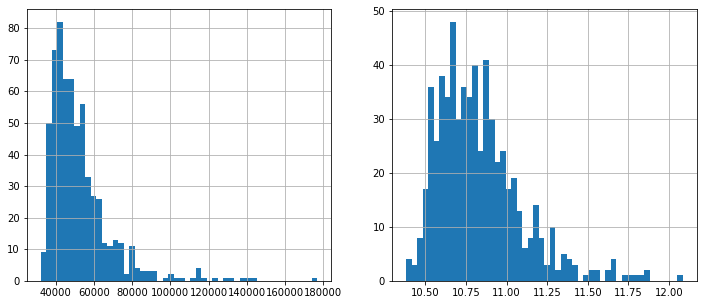

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['Household Income Median'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['Household Income Median'])).hist(bins=50, ax=ax[1])
plt.show()
#haivy-tailed, makes sense to apply log transform before min-max rescaling

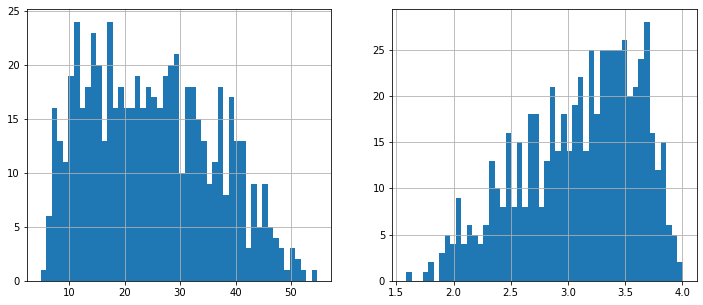

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['IOD AVG'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['IOD AVG'])).hist(bins=50, ax=ax[1])
plt.show()
#no sense to apply log transform

In [12]:
df_atlas['Household Income Median'] = df_atlas['Household Income Median'].apply(np.log)
df_atlas = standartize(df_atlas, wealth_cols)

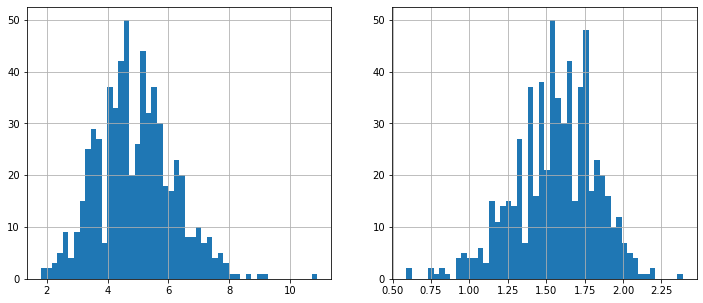

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['Bad Health'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['Bad Health'])).hist(bins=50, ax=ax[1])
plt.show()
#no sense to apply log transform

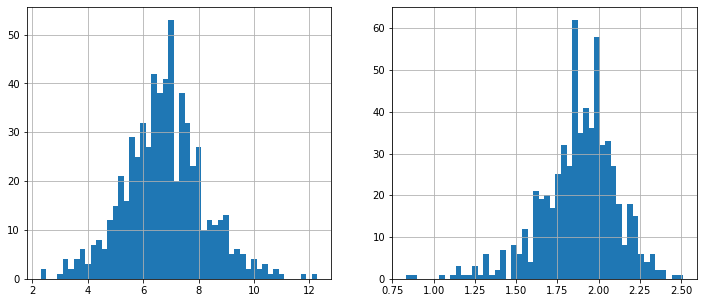

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['Limited activities'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['Limited activities'])).hist(bins=50, ax=ax[1])
plt.show()
#no sense to apply log transform

In [15]:
df_atlas = standartize(df_atlas, disability_cols)

The indices of deprivation measure how deprived an area is [source](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/464597/English_Indices_of_Deprivation_2015_-_Research_Report.pdf). In essence, these indicators indicate how impoverished an area is. The linked documents lists the meaning of the different indices. *The average score measure summarises the average level of deprivation across the higher-level area,based on the scores of the Lower-layer Super Output Areas in the area.* Therefore, we decided to keep only this measure, as we are interested in an indicator of "average impoverishment".

In [16]:
df_ward.columns.values

array(['weight', 'weight_perc2.5', 'weight_perc25', 'weight_perc50',
       'weight_perc75', 'weight_perc97.5', 'weight_std', 'weight_ci95',
       'volume', 'volume_perc2.5', 'volume_perc25', 'volume_perc50',
       'volume_perc75', 'volume_perc97.5', 'volume_std', 'volume_ci95',
       'fat', 'fat_perc2.5', 'fat_perc25', 'fat_perc50', 'fat_perc75',
       'fat_perc97.5', 'fat_std', 'fat_ci95', 'saturate',
       'saturate_perc2.5', 'saturate_perc25', 'saturate_perc50',
       'saturate_perc75', 'saturate_perc97.5', 'saturate_std',
       'saturate_ci95', 'salt', 'salt_perc2.5', 'salt_perc25',
       'salt_perc50', 'salt_perc75', 'salt_perc97.5', 'salt_std',
       'salt_ci95', 'sugar', 'sugar_perc2.5', 'sugar_perc25',
       'sugar_perc50', 'sugar_perc75', 'sugar_perc97.5', 'sugar_std',
       'sugar_ci95', 'protein', 'protein_perc2.5', 'protein_perc25',
       'protein_perc50', 'protein_perc75', 'protein_perc97.5',
       'protein_std', 'protein_ci95', 'carb', 'carb_perc2.5',
      

In [17]:
important_cols = ['weight', 'volume', 'fat', 'saturate', 'salt', 'sugar', 'protein', 'carb',
                 'fibre', 'alcohol', 'energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot', 'f_energy_fat', 'f_energy_saturate', 
                 'f_energy_sugar', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol', 
                 'energy_density', 'h_nutrients_weight', 'h_nutrients_weight_norm', 'h_nutrients_calories',
                  'h_nutrients_calories_norm', 'representativeness_norm']

In [18]:
# before merging set index of df_atlas to the ward code
df_atlas.set_index('New Code', drop=True, inplace=True)

In [19]:
# merge the data sets by ward
df_ward_atlas = pd.merge(df_ward[important_cols], df_atlas, how='inner', left_index=True, right_index=True, validate='1:1')
df_ward_atlas

,weight,volume,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,Level 2 qualifications,Apprenticeship qualifications,Level 3 qualifications,Level >=4 qualifications,Other qualifications,% of 16+ who are schoolchildren and full-time students: Age 18 and over,Bad Health,Limited activities,Well-Being,IOD AVG
E05000026,449.535137,125.960833,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,0.115,0.011,0.085,0.345,0.167,14.3,-0.492858,-1.121216,7.897959,0.694138
E05000027,413.130263,110.664114,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,0.157,0.018,0.093,0.167,0.089,5.8,1.409580,1.429760,7.358842,0.992115
E05000028,407.100472,121.990710,9.216310,3.613582,0.610536,10.690272,5.192412,19.662048,1.572323,0.225425,...,0.153,0.020,0.091,0.206,0.100,7.7,1.647385,1.429760,7.609123,0.601395
E05000029,384.173858,122.245578,9.700137,3.961264,0.533180,12.938606,4.718184,20.084734,1.550344,0.200380,...,0.149,0.022,0.100,0.195,0.083,5.3,1.488848,2.119213,7.108108,1.168602
E05000030,356.882607,109.959688,9.381808,3.614663,0.566784,11.332898,5.307003,19.581403,1.607947,0.168952,...,0.165,0.028,0.100,0.185,0.061,5.0,0.775434,1.291869,7.887917,0.065051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E05000645,387.651694,100.374890,9.011954,3.558849,0.584727,9.403091,5.499603,16.729870,1.609476,0.292334,...,0.076,0.009,0.080,0.551,0.099,6.4,0.616897,0.257690,7.653520,-0.504062
E05000646,391.296517,102.209867,8.810350,3.379945,0.604999,9.350598,5.584789,17.240961,1.640990,0.209072,...,0.081,0.009,0.088,0.531,0.104,7.7,0.537629,0.188745,7.578400,-0.262902
E05000647,391.146713,115.080184,8.642757,3.398100,0.584833,9.446028,5.321004,17.579308,1.680360,0.299310,...,0.071,0.010,0.085,0.585,0.097,7.7,0.220556,-0.500708,8.185989,-0.452034
E05000648,400.832576,109.727023,8.919674,3.512147,0.549463,9.623928,5.259262,17.940815,1.611090,0.195706,...,0.096,0.008,0.089,0.357,0.131,7.4,2.994945,2.739721,8.000000,1.459673


In [20]:
carb_energy_corr = df_ward_atlas[all_features].corrwith(df_ward_atlas['energy_carb'], method='pearson')
carb_energy_corr = carb_energy_corr.sort_values(ascending=False, key=np.abs)
carb_energy_corr

Level 1 qualifications           0.824816
Level >=4 qualifications        -0.787306
Level 2 qualifications           0.772630
No qualifications                0.686948
Apprenticeship qualifications    0.643280
Household Income Median         -0.622505
Aged 16-64                      -0.575291
Aged 0-15                        0.499667
Religion not stated             -0.476486
Mixed                           -0.413051
Limited activities               0.382785
No religion                     -0.374852
Buddhist                        -0.343616
Other                           -0.307474
Jewish                          -0.305896
Not Born in UK                  -0.300743
Born in UK                       0.300743
Aged 65+                         0.260227
Asian or Asian British           0.249848
Hindu                            0.233352
Sikh                             0.232523
Christian                        0.206357
Bad Health                       0.202186
White                           -0

In [21]:
#get rid of linearly dependent cols
for cols in [age_cols, ethnicities_cols, religion_cols, born_cols, qualilication_cols]:
    carb_energy_corr.drop(carb_energy_corr[cols].index[-1], axis=0, inplace=True)

In [22]:
carb_energy_corr

Level 1 qualifications           0.824816
Level >=4 qualifications        -0.787306
Level 2 qualifications           0.772630
No qualifications                0.686948
Apprenticeship qualifications    0.643280
Household Income Median         -0.622505
Aged 16-64                      -0.575291
Aged 0-15                        0.499667
Mixed                           -0.413051
Limited activities               0.382785
No religion                     -0.374852
Buddhist                        -0.343616
Jewish                          -0.305896
Born in UK                       0.300743
Asian or Asian British           0.249848
Hindu                            0.233352
Sikh                             0.232523
Christian                        0.206357
Bad Health                       0.202186
White                           -0.160661
Level 3 qualifications           0.157957
Muslim                           0.134663
Black or Black British           0.075192
IOD AVG                          0

In [23]:
def forward_feature_selection(df_corrs, target_col, verbose=False):

    num_features = 1
    repeat = 100
    best_score = 0
    best_num_features = 0
    delay = 10
    not_improvements = 0

    while (not_improvements < delay) and (num_features < len(df_corrs)):
        features = list(df_corrs[:num_features].keys())
        x_data = df_ward_atlas[features]
        y_data = df_ward_atlas[target_col]
        res_train = []
        res_test = []
        for i in range(repeat):
            x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 1/3)
            model = LinearRegression()
            model.fit(x_train, y_train)
            res_train.append(model.score(x_train, y_train))
            res_test.append(model.score(x_test, y_test))
        res_train = np.array(res_train)
        res_test = np.array(res_test)
        res_train = np.mean(res_train)
        res_test = np.mean(res_test)
        if (res_test > best_score):
            summary_str = 'R2 score on test data improved by {:.5}'.format(res_test-best_score)
            best_score = res_test
            best_num_features = num_features
            not_improvements = 0
        else:
            summary_str = 'R2 score on test data did not improved'
            not_improvements += 1
        if verbose:
            print('Added feature {}: {}'.format(num_features, df_corrs.keys()[num_features-1]))
            print('Average r2_score on train data: {:.5}, on test data {:.5}'.format(res_train, res_test))
            print(summary_str + '\n')
        num_features += 1
    
    return best_score, best_num_features

In [24]:
def forward_feature_selection_brute_force(df_corrs_, target_col, verbose=False):
    num_features = 1
    repeat = 100
    global_test_best = 0
    selected_cols_best = None
    delay = 3
    not_improvements = 0

    df_corrs = df_corrs_.copy()
    selected_cols = []

    while (not_improvements < delay) and (len(df_corrs) > 0):
        res_train = {}
        res_test = {}
        local_train_best = 0
        local_test_best = 0
        best_new_col = None
        for new_col in df_corrs.index:
            trial_cols = selected_cols + [new_col]       
            x_data = df_ward_atlas[trial_cols]
            y_data = df_ward_atlas[target_col]
            res_train[new_col] = []
            res_test[new_col] = []
            for i in range(repeat):
                x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 1/3)
                model = LinearRegression()
                model.fit(x_train, y_train)
                res_train[new_col].append(model.score(x_train, y_train))
                res_test[new_col].append(model.score(x_test, y_test))
            res_train[new_col] = np.array(res_train[new_col])
            res_test[new_col] = np.array(res_test[new_col])
            res_train[new_col] = np.mean(res_train[new_col])
            res_test[new_col] = np.mean(res_test[new_col])
            if (res_test[new_col] > local_test_best):
                local_test_best = res_test[new_col]
                local_train_best = res_train[new_col]
                best_new_col = new_col
        
        selected_cols.append(best_new_col)
        df_corrs.drop(best_new_col, axis=0, inplace=True)
        if (local_test_best > global_test_best):
            summary_str = 'R2 score on test data improved by {:.5}'.format(local_test_best-global_test_best)
            global_test_best = local_test_best
            selected_cols_best = selected_cols.copy()
            not_improvements = 0
        else:
            summary_str = 'R2 score on test data did not improved'
            not_improvements += 1
        if verbose:
            print('Added feature {}: {}'.format(num_features, best_new_col))
            print('Average r2_score on train data: {:.5}, on test data {:.5}'.format(local_train_best, local_test_best))
            print(summary_str + '\n')
        num_features += 1
        
    return global_test_best, selected_cols_best

In [78]:
global_test_best, selected_cols_best  = forward_feature_selection_brute_force(carb_energy_corr, 'energy_carb')

Added feature 1: Level 1 qualifications
Average r2_score on train data: 0.68185, on test data 0.6715
R2 score on test data improved by 0.6715

Added feature 2: Mixed
Average r2_score on train data: 0.71433, on test data 0.70443
R2 score on test data improved by 0.032934

Added feature 3: Jewish
Average r2_score on train data: 0.73438, on test data 0.72843
R2 score on test data improved by 0.023998

Added feature 4: Asian or Asian British
Average r2_score on train data: 0.75126, on test data 0.74344
R2 score on test data improved by 0.015014

Added feature 5: Level 2 qualifications
Average r2_score on train data: 0.76619, on test data 0.74868
R2 score on test data improved by 0.0052364

Added feature 6: Muslim
Average r2_score on train data: 0.76563, on test data 0.75919
R2 score on test data improved by 0.010511

Added feature 7: No religion
Average r2_score on train data: 0.77378, on test data 0.76783
R2 score on test data improved by 0.0086428

Added feature 8: Level >=4 qualificatio

In [ ]:
global_test_best, selected_cols_best  = forward_feature_selection_brute_force(carb_energy_corr, 'energy_carb')

In [79]:
print(global_test_best)
print(selected_cols_best)

0.7708398809492684
['Level 1 qualifications', 'Mixed', 'Jewish', 'Asian or Asian British', 'Level 2 qualifications', 'Muslim', 'No religion', 'Level >=4 qualifications']


In [36]:
target_cols = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot']
global_test_best = {}
selected_cols_best = {}
energy_corr = {}
for y in target_cols:
    energy_corr[y] = df_ward_atlas[all_features].corrwith(df_ward_atlas[y], method='pearson')
    energy_corr[y] = energy_corr[y].sort_values(ascending=False, key=np.abs)
    #get rid of linearly dependent cols
    for cols in [age_cols, ethnicities_cols, religion_cols, born_cols, qualilication_cols]:
        energy_corr[y].drop(energy_corr[y][cols].index[-1], axis=0, inplace=True)
    global_test_best[y], selected_cols_best[y]  = forward_feature_selection_brute_force(energy_corr[y], y)
    print('{}: best r2 score = {:.5f}, num features = {}'.format(y, global_test_best[y], len(selected_cols_best[y])))

energy_fat: best r2 score = 0.34637, num features = 10
energy_saturate: best r2 score = 0.34950, num features = 11
energy_sugar: best r2 score = 0.59490, num features = 13
energy_protein: best r2 score = 0.61036, num features = 15
energy_carb: best r2 score = 0.76988, num features = 9
energy_fibre: best r2 score = 0.58866, num features = 10
energy_alcohol: best r2 score = 0.39419, num features = 8
energy_tot: best r2 score = 0.65720, num features = 9


In [50]:
for y in target_cols:
    print(f'features for \'{y}\' prediction:', selected_cols_best[y])

features for 'energy_fat' prediction: ['Level 1 qualifications', 'Jewish', 'Mixed', 'Aged 0-15', 'Christian', 'Black or Black British', 'Muslim', 'No religion', 'Asian or Asian British', 'IOD AVG']
features for 'energy_saturate' prediction: ['Asian or Asian British', 'Born in UK', 'Muslim', 'White', 'Jewish', 'Aged 0-15', 'Mixed', 'Apprenticeship qualifications', 'Level 1 qualifications', 'Level 3 qualifications', 'Other religions']
features for 'energy_sugar' prediction: ['Level 1 qualifications', 'Black or Black British', 'Bad Health', 'White', 'Hindu', 'Mixed', 'Asian or Asian British', 'No religion', 'Aged 0-15', 'Christian', 'Muslim', 'IOD AVG', 'Apprenticeship qualifications']
features for 'energy_protein' prediction: ['Asian or Asian British', 'Jewish', 'Level 1 qualifications', 'Sikh', 'Muslim', 'No religion', 'Level 2 qualifications', 'Christian', 'IOD AVG', 'Household Income Median', 'Apprenticeship qualifications', 'Buddhist', 'Level >=4 qualifications', 'Born in UK', 'Aged 

In [25]:
def to_formula(cols):
    cols = list(map(lambda s: 'Q("{}")'.format(s), cols))
    return ' + '.join(cols)

# Linear model for energy_fat

In [53]:
target = 'energy_fat'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             energy_fat   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     27.63
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           1.50e-41
Time:                        01:33:49   Log-Likelihood:                -1160.8
No. Observations:                 483   AIC:                             2344.
Df Residuals:                     472   BIC:                             2390.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Statistically significant features (with p-value < 0.05): Black or Black British, Asian or Asian British (etnicities), Jewish, Muslim, No religion (religions), Level 1 qualifications, Aged 0-15. More precisely, we see that amount of consumed energy from fats depends on:
1) Etnicity: less for Black or Black British, more for Asian or Asian British. <br>
2) Religion: less for Jewish, more for Muslim and people with no religion. <br>
3) Qualification: more for people with the lowest qualification. <br>
4) Age: more for children (age 0-15)

# Linear model for energy_saturate

In [57]:
target = 'energy_saturate'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        energy_saturate   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     26.13
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           2.36e-42
Time:                        01:43:30   Log-Likelihood:                -785.08
No. Observations:                 483   AIC:                             1594.
Df Residuals:                     471   BIC:                             1644.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# Linear model for energy_sugar

In [59]:
target = 'energy_sugar'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           energy_sugar   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     54.56
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           3.82e-85
Time:                        01:45:33   Log-Likelihood:                -1112.2
No. Observations:                 483   AIC:                             2252.
Df Residuals:                     469   BIC:                             2311.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# Linear model for energy_protein

In [60]:
target = 'energy_protein'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         energy_protein   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     55.17
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           3.27e-93
Time:                        01:47:22   Log-Likelihood:                -384.19
No. Observations:                 483   AIC:                             800.4
Df Residuals:                     467   BIC:                             867.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# Linear model for energy_carb

In [58]:
target = 'energy_carb'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            energy_carb   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     181.4
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          3.14e-147
Time:                        01:44:00   Log-Likelihood:                -1151.7
No. Observations:                 483   AIC:                             2323.
Df Residuals:                     473   BIC:                             2365.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Statistically significant features (with p-value < 0.05): White, Mixed (etnicities), Jewish (religion), Born in UK, Limited activities, Level >=4 qualifications (i. e. maximum level of qualification). More precisely, we see that amount of energy consumed from carbohidrates depends on:
1) Etnicity: less for white and (especially) mixed people than in average
2) Religion: less for Jewish people
3) Place of birth: more for people born in UK than for those who were born abroad
4) Health state: less for people whose Day-to-day activities are limited a lot
5) Qualification: less for highly qualified people, more for low qualified. Here results for 'No qualifications' may be skewed, because this category probably includes all children independently of their mental abilities.

# Linear model for energy_fibre

In [61]:
target = 'energy_fibre'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           energy_fibre   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     72.19
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           1.40e-88
Time:                        01:48:23   Log-Likelihood:                 485.00
No. Observations:                 483   AIC:                            -948.0
Df Residuals:                     472   BIC:                            -902.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

# Linear model for energy_alcohol

In [62]:
target = 'energy_alcohol'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         energy_alcohol   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     41.65
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           2.60e-50
Time:                        01:49:36   Log-Likelihood:                -63.078
No. Observations:                 483   AIC:                             144.2
Df Residuals:                     474   BIC:                             181.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# Linear model for energy_tot

In [63]:
target = 'energy_tot'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             energy_tot   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     102.5
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          3.32e-105
Time:                        01:51:37   Log-Likelihood:                -1405.3
No. Observations:                 483   AIC:                             2831.
Df Residuals:                     473   BIC:                             2872.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# Predicting a fraction of each nutrient energy

In [25]:
target_cols = ['f_energy_fat', 'f_energy_saturate', 
                 'f_energy_sugar', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol']
global_test_best = {}
selected_cols_best = {}
energy_corr = {}
for y in target_cols:
    energy_corr[y] = df_ward_atlas[all_features].corrwith(df_ward_atlas[y], method='pearson')
    energy_corr[y] = energy_corr[y].sort_values(ascending=False, key=np.abs)
    #get rid of linearly dependent cols
    for cols in [age_cols, ethnicities_cols, religion_cols, born_cols, qualilication_cols]:
        energy_corr[y].drop(energy_corr[y][cols].index[-1], axis=0, inplace=True)
    global_test_best[y], selected_cols_best[y]  = forward_feature_selection_brute_force(energy_corr[y], y)
    print('{}: best r2 score = {:.5f}, num features = {}'.format(y, global_test_best[y], len(selected_cols_best[y])))

f_energy_fat: best r2 score = 0.47521, num features = 9
f_energy_saturate: best r2 score = 0.43184, num features = 10
f_energy_sugar: best r2 score = 0.43231, num features = 8
f_energy_protein: best r2 score = 0.70012, num features = 8
f_energy_carb: best r2 score = 0.72733, num features = 8
f_energy_fibre: best r2 score = 0.76821, num features = 15
f_energy_alcohol: best r2 score = 0.45613, num features = 14


In [26]:
for y in target_cols:
    print(f'features for \'{y}\' prediction:', selected_cols_best[y])

features for 'f_energy_fat' prediction: ['Level 2 qualifications', 'Black or Black British', 'Mixed', 'Apprenticeship qualifications', 'Born in UK', 'Aged 0-15', 'Hindu', 'No religion', 'No qualifications']
features for 'f_energy_saturate' prediction: ['Level 2 qualifications', 'No religion', 'Black or Black British', 'Mixed', 'Muslim', 'Aged 16-64', 'Other religions', 'Level 1 qualifications', 'No qualifications', 'Level 3 qualifications']
features for 'f_energy_sugar' prediction: ['Level 1 qualifications', 'Black or Black British', 'Asian or Asian British', 'IOD AVG', 'No religion', 'Apprenticeship qualifications', 'Jewish', 'Christian']
features for 'f_energy_protein' prediction: ['Level >=4 qualifications', 'Asian or Asian British', 'Level 1 qualifications', 'Mixed', 'Aged 0-15', 'Sikh', 'No religion', 'Christian']
features for 'f_energy_carb' prediction: ['Level 1 qualifications', 'Hindu', 'Level 2 qualifications', 'White', 'Mixed', 'Born in UK', 'Sikh', 'Black or Black British']


In [77]:
selected_cols_best = {}
selected_cols_best['f_energy_fat'] = ['Level 2 qualifications', 'Black or Black British', 'Mixed', 
                                      'Apprenticeship qualifications', 'Born in UK', 'Aged 0-15', 'Hindu', 
                                      'No religion', 'No qualifications']

In [78]:
target = 'f_energy_fat'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           f_energy_fat   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     51.27
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           1.83e-64
Time:                        16:55:49   Log-Likelihood:                 1655.6
No. Observations:                 483   AIC:                            -3291.
Df Residuals:                     473   BIC:                            -3249.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# Neural Network for predicting all at once

In [28]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import KLDivergence

In [29]:
target_cols = ['f_energy_fat', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol']

In [36]:
df_ward_atlas[target_cols].sum(axis=1)

E05000026    1.0
E05000027    1.0
E05000028    1.0
E05000029    1.0
E05000030    1.0
            ... 
E05000645    1.0
E05000646    1.0
E05000647    1.0
E05000648    1.0
E05000649    1.0
Length: 483, dtype: float64

In [37]:
any(np.abs(df_ward_atlas[target_cols].sum(axis=1) - 1 > 0.01))

False

In [63]:
model = Sequential()
model.add(Input(shape=(30,)))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='sgd', 
              loss=KLDivergence(), 
              metrics=['mean_absolute_error'])

In [60]:
x_data = df_ward_atlas[all_features]
y_data = df_ward_atlas[target_cols]
#x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

In [64]:
history = model.fit(x_data, y_data, validation_split=0.2, epochs=300)

Train on 386 samples, validate on 97 samples
Epoch 1/300
386/386 [==============================] - 0s 223us/sample - loss: 0.6217 - mean_absolute_error: 0.1945 - val_loss: 0.4717 - val_mean_absolute_error: 0.1681
Epoch 2/300
386/386 [==============================] - 0s 38us/sample - loss: 0.5361 - mean_absolute_error: 0.1789 - val_loss: 0.4070 - val_mean_absolute_error: 0.1544
Epoch 3/300
386/386 [==============================] - 0s 47us/sample - loss: 0.4643 - mean_absolute_error: 0.1648 - val_loss: 0.3514 - val_mean_absolute_error: 0.1417
Epoch 4/300
386/386 [==============================] - 0s 54us/sample - loss: 0.4010 - mean_absolute_error: 0.1510 - val_loss: 0.3049 - val_mean_absolute_error: 0.1301
Epoch 5/300
386/386 [==============================] - 0s 54us/sample - loss: 0.3477 - mean_absolute_error: 0.1383 - val_loss: 0.2665 - val_mean_absolute_error: 0.1194
Epoch 6/300
386/386 [==============================] - 0s 53us/sample - loss: 0.3057 - mean_absolute_error: 0.1273

386/386 [==============================] - 0s 72us/sample - loss: 0.0254 - mean_absolute_error: 0.0213 - val_loss: 0.0198 - val_mean_absolute_error: 0.0199
Epoch 49/300
386/386 [==============================] - 0s 67us/sample - loss: 0.0247 - mean_absolute_error: 0.0209 - val_loss: 0.0193 - val_mean_absolute_error: 0.0196
Epoch 50/300
386/386 [==============================] - 0s 57us/sample - loss: 0.0240 - mean_absolute_error: 0.0206 - val_loss: 0.0188 - val_mean_absolute_error: 0.0193
Epoch 51/300
386/386 [==============================] - 0s 62us/sample - loss: 0.0233 - mean_absolute_error: 0.0203 - val_loss: 0.0183 - val_mean_absolute_error: 0.0191
Epoch 52/300
386/386 [==============================] - 0s 54us/sample - loss: 0.0227 - mean_absolute_error: 0.0200 - val_loss: 0.0178 - val_mean_absolute_error: 0.0188
Epoch 53/300
386/386 [==============================] - 0s 49us/sample - loss: 0.0221 - mean_absolute_error: 0.0197 - val_loss: 0.0173 - val_mean_absolute_error: 0.0186

386/386 [==============================] - 0s 43us/sample - loss: 0.0089 - mean_absolute_error: 0.0134 - val_loss: 0.0074 - val_mean_absolute_error: 0.0132
Epoch 97/300
386/386 [==============================] - 0s 44us/sample - loss: 0.0087 - mean_absolute_error: 0.0133 - val_loss: 0.0073 - val_mean_absolute_error: 0.0131
Epoch 98/300
386/386 [==============================] - 0s 44us/sample - loss: 0.0086 - mean_absolute_error: 0.0132 - val_loss: 0.0072 - val_mean_absolute_error: 0.0130
Epoch 99/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0084 - mean_absolute_error: 0.0131 - val_loss: 0.0071 - val_mean_absolute_error: 0.0130
Epoch 100/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0083 - mean_absolute_error: 0.0130 - val_loss: 0.0070 - val_mean_absolute_error: 0.0129
Epoch 101/300
386/386 [==============================] - 0s 44us/sample - loss: 0.0082 - mean_absolute_error: 0.0130 - val_loss: 0.0069 - val_mean_absolute_error: 0.01

Epoch 144/300
386/386 [==============================] - 0s 38us/sample - loss: 0.0047 - mean_absolute_error: 0.0106 - val_loss: 0.0042 - val_mean_absolute_error: 0.0107
Epoch 145/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0047 - mean_absolute_error: 0.0106 - val_loss: 0.0042 - val_mean_absolute_error: 0.0106
Epoch 146/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0046 - mean_absolute_error: 0.0106 - val_loss: 0.0041 - val_mean_absolute_error: 0.0106
Epoch 147/300
386/386 [==============================] - 0s 39us/sample - loss: 0.0046 - mean_absolute_error: 0.0105 - val_loss: 0.0041 - val_mean_absolute_error: 0.0106
Epoch 148/300
386/386 [==============================] - 0s 35us/sample - loss: 0.0045 - mean_absolute_error: 0.0105 - val_loss: 0.0041 - val_mean_absolute_error: 0.0105
Epoch 149/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0045 - mean_absolute_error: 0.0104 - val_loss: 0.0040 - val_mean_abs

386/386 [==============================] - 0s 41us/sample - loss: 0.0032 - mean_absolute_error: 0.0093 - val_loss: 0.0030 - val_mean_absolute_error: 0.0093
Epoch 193/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0032 - mean_absolute_error: 0.0093 - val_loss: 0.0030 - val_mean_absolute_error: 0.0092
Epoch 194/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0032 - mean_absolute_error: 0.0092 - val_loss: 0.0030 - val_mean_absolute_error: 0.0092
Epoch 195/300
386/386 [==============================] - 0s 40us/sample - loss: 0.0031 - mean_absolute_error: 0.0092 - val_loss: 0.0030 - val_mean_absolute_error: 0.0092
Epoch 196/300
386/386 [==============================] - 0s 39us/sample - loss: 0.0031 - mean_absolute_error: 0.0092 - val_loss: 0.0030 - val_mean_absolute_error: 0.0092
Epoch 197/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0031 - mean_absolute_error: 0.0092 - val_loss: 0.0029 - val_mean_absolute_error: 0

386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0025 - val_mean_absolute_error: 0.0086
Epoch 241/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0025 - val_mean_absolute_error: 0.0086
Epoch 242/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0.0085
Epoch 243/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0.0085
Epoch 244/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0.0086
Epoch 245/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0

386/386 [==============================] - 0s 41us/sample - loss: 0.0021 - mean_absolute_error: 0.0080 - val_loss: 0.0022 - val_mean_absolute_error: 0.0081
Epoch 289/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0021 - mean_absolute_error: 0.0080 - val_loss: 0.0022 - val_mean_absolute_error: 0.0081
Epoch 290/300
386/386 [==============================] - 0s 39us/sample - loss: 0.0021 - mean_absolute_error: 0.0080 - val_loss: 0.0021 - val_mean_absolute_error: 0.0080
Epoch 291/300
386/386 [==============================] - 0s 37us/sample - loss: 0.0021 - mean_absolute_error: 0.0080 - val_loss: 0.0021 - val_mean_absolute_error: 0.0080
Epoch 292/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0021 - mean_absolute_error: 0.0080 - val_loss: 0.0021 - val_mean_absolute_error: 0.0080
Epoch 293/300
386/386 [==============================] - 0s 38us/sample - loss: 0.0021 - mean_absolute_error: 0.0080 - val_loss: 0.0021 - val_mean_absolute_error: 0

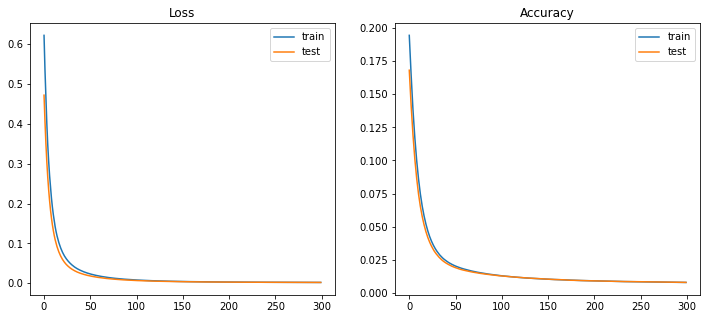

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='test')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history.history['mean_absolute_error'], label='train')
ax[1].plot(history.history['val_mean_absolute_error'], label='test')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()